# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/train.p"
testing_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print (y_train)

[ 0  0  0 ..., 42 42 42]


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[1].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

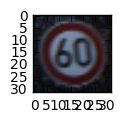

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import numpy as np

# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()


plt.figure(figsize=(1,1))
plt.imshow(image)

In [ ]:
yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
plt.figure(figsize=(1,1))
plt.imshow(yuv[:, :, 0])

# convert data type to float
yuv_float = np.float32(yuv)
yuv_float = yuv_float * 1.0/255.0
y_float = yuv_float[:, :, 0]

mean = cv2.GaussianBlur(y_float, (11, 11), 1, 1)
yuv_norm = y_float - mean

plt.figure(figsize=(1,1))
plt.imshow(mean)

plt.figure(figsize=(1,1))
plt.imshow(yuv_norm)

variance = cv2.GaussianBlur(np.multiply(yuv_norm, yuv_norm), (11, 11), 1, 1)
variance_mean = np.mean(variance)
variance_max = np.maximum(variance, variance_mean)
print(variance_mean)

std = np.sqrt(variance_max)

plt.figure(figsize=(1,1))
plt.imshow(variance_max)
#print(np.multiply(yuv_norm, yuv_norm))

yuv_local_norm = np.divide(yuv_norm, std)

#print (index)
plt.figure(figsize=(1,1))
plt.imshow(yuv_local_norm)


yuv_global_norm = cv2.normalize(yuv_local_norm, 0.0, 1.0)
plt.figure(figsize=(1,1))
plt.imshow(yuv_global_norm)



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
# Global normalization
from sklearn import preprocessing
import cv2

def image_preprocessing(image):
    '''
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    c11 = clahe.apply(yuv[:, :, 0])
    std_image_y = preprocessing.scale(c11)
    '''
    
    '''
    std_image_u = preprocessing.scale(yuv[:, :, 1])
    std_image_v = preprocessing.scale(yuv[:, :, 2])
    
    yuv_norm = np.zeros(yuv.shape, dtype=std_image_y.dtype)
    
    yuv_norm[:, :, 0] = std_image_y;
    yuv_norm[:, :, 1] = std_image_u;
    yuv_norm[:, :, 2] = std_image_v;
    '''
    '''
    yuv_norm = np.zeros((yuv.shape[0], yuv.shape[1], 1), dtype=std_image_y.dtype)
    yuv_norm[:, :, 0] = std_image_y
    '''    
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # convert data type to float
    yuv_float = np.float32(yuv)
    yuv_float = yuv_float * 1.0/255.0
    y_float = yuv_float[:, :, 0]
    
    # Center image to zero mean
    mean = cv2.GaussianBlur(y_float, (11, 11), 1, 1)
    yuv_zero_mean = y_float - mean

    # scale to normalize std
    variance = cv2.GaussianBlur(np.multiply(yuv_zero_mean, yuv_zero_mean), (11, 11), 1, 1)
    variance_mean = np.mean(variance)
    variance_max = np.maximum(variance, variance_mean)

    std = np.sqrt(variance_max)

    yuv_local_norm = np.divide(yuv_zero_mean, std)
    yuv_global_norm = cv2.normalize(yuv_local_norm, 0.0, 1.0)
    
    yuv_norm = np.zeros((yuv.shape[0], yuv.shape[1], 1), dtype=yuv_global_norm.dtype)
    yuv_norm[:, :, 0] = yuv_global_norm
    
    return yuv_norm


print("Preprocessing training data...")
X_train_processed = []
for img in X_train:
    X_train_processed.append(image_preprocessing(img))
    
X_train_processed = np.concatenate([img[np.newaxis] for img in X_train_processed])
X_train = X_train_processed;
print("done")
print(X_train.shape)


print("Preprocessing testing data...")
X_test_processed = []
for img in X_test:
    X_test_processed.append(image_preprocessing(img))
    
X_test_processed = np.concatenate([img[np.newaxis] for img in X_test_processed])
X_test = X_test_processed;
print("done")
print(X_test.shape)


Preprocessing training data...
done
(39209, 32, 32, 1)
Preprocessing testing data...
done
(12630, 32, 32, 1)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
I first converted all the training and testing image into YUV. Then I standardized them by shifting and scaling the distribution of pixel values to have zero mean and unit variance. I standardized the image for numerical stability and also faster convergence.

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift
from scipy.ndimage.interpolation import zoom

sess = tf.InteractiveSession()

# Rotate images
def randomRotation(lower, upper, image):
    angle = random.uniform(lower, upper)
    #print ("Rotate Image for: ", angle)
    rotated = rotate(image, angle, reshape=False)
    return rotated

# Translate images
def randomShift(lower, upper, image):
    delta = random.uniform(lower, upper)
    #print ("Shift Image for: ", delta)
    shifted = shift(image, [delta, delta, 0])
    return shifted

# Zoom images
def randomZoom(lower, upper, image):
    scale = random.uniform(lower, upper)
    #print ("Scale Image for: ", scale)
    zoomed = zoom(image, [scale, scale, 1])
    # start idx for crop or padding
    zoomed_hw = zoomed.shape[:2]
    input_hw = image.shape[:2]    
    start_idx = abs(np.divide(np.add(zoomed_hw, np.multiply(input_hw, -1)), 2))
    start_idx = start_idx.astype(int)

    output = np.zeros(image.shape, dtype=image.dtype)
    if scale >= 1:
        end_idx = np.add(start_idx, input_hw) 
        output = zoomed[start_idx[0]:end_idx[0], start_idx[1]:end_idx[1], :]
    else:
        end_idx = np.add(start_idx, zoomed_hw)
        output[start_idx[0]:end_idx[0], start_idx[1]:end_idx[1], :] = zoomed
    return output


In [7]:
additional_img = []
additional_label = []
print ("Rotatin, Shifting, Zooming...")
for i in range(X_train.shape[0]):
    # Rotate
    rotated_img = randomRotation(-15.0, 15.0, X_train[i])
    additional_img.append(rotated_img)
    additional_label.append(y_train[i])
    
    # Shift
    shifted_img = randomShift(-2.0, 2.0, X_train[i])
    additional_img.append(shifted_img)
    additional_label.append(y_train[i])
    
    # Zoom
    zoomed_img = randomZoom(0.9, 1.1, X_train[i])
    additional_img.append(zoomed_img)
    additional_label.append(y_train[i])
    
print ("Number of Transformed image = ", len(additional_img))
print ("Number of Transformed image label = ", len(additional_label))

Rotatin, Shifting, Zooming...


/home/linfeng-zc/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/linfeng-zc/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


Number of Transformed image =  117627
Number of Transformed image label =  117627


In [8]:
additional_imgs = np.concatenate([img[np.newaxis] for img in additional_img])
additional_labels = np.concatenate([label[np.newaxis] for label in additional_label])

X_train = np.vstack((X_train, additional_imgs))
y_train = np.hstack((y_train, additional_labels))
print ("Dimension of new training set = ", X_train.shape)
print ("Dimension of new training result = ", y_train.shape)

Dimension of new training set =  (156836, 32, 32, 1)
Dimension of new training result =  (156836,)


(32, 32)


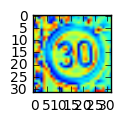

In [9]:
print (X_train[156835,:,:,0].shape)
plt.figure(figsize=(1,1))
plt.imshow(X_train[336,:,:,0])

In [10]:
# Save preprocessed data
new_training_data = {'features' : X_train, 'labels': y_train}
new_testing_data = {'features' : X_test, 'labels': y_test}

new_training_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/new_train.p"
new_testing_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/new_test.p"

pickle.dump( new_training_data, open( new_training_file, "wb" ) )
pickle.dump( new_testing_data, open( new_testing_file, "wb" ) )

In [11]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load new training data
training_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/new_train.p"
testing_file = "/home/linfeng-zc/Documents/Udacity/CarND-Traffic-Sign-Classifier-Project/traffic-signs-data/new_test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print ("Dimension of new training set = ", X_train.shape)
print ("Dimension of new training result = ", y_train.shape)


Dimension of new training set =  (156836, 32, 32, 1)
Dimension of new training result =  (156836,)


In [12]:
# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

# Split data into training and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
print("Update Image Shape: {}".format(X_train[0].shape))

Update Image Shape: (32, 32, 1)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

First, I added more data by randomly rotating(-15, 15), translating(-2.0, 2.0) and scaling(0.9, 1.1) the original training data (based on LeCun's papaer) because convolutional networks have invariant to small scale, translation and rotation.

After that, I shuffled the original training data and then split them into 80% training and 20% validation.

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 15
BATCH_SIZE = 128

In [14]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    layer_depth = {
        'layer_1': 6,
        'layer_2': 16,
        'layer_3': 120,
        'layer_4': 84,
        'layer_5': 43
    }
    
    weights = {
        'layer_1': tf.Variable(tf.truncated_normal(
            [5, 5, 1, layer_depth['layer_1']], mu, sigma)),
        'layer_2': tf.Variable(tf.truncated_normal(
            [5, 5, layer_depth['layer_1'], layer_depth['layer_2']], mu, sigma)),
        'layer_3': tf.Variable(tf.truncated_normal(
            [14*14*layer_depth['layer_1'] + 5*5*layer_depth['layer_2'], layer_depth['layer_3']], mu, sigma)),
        #'layer_3': tf.Variable(tf.truncated_normal(
        #    [5*5*layer_depth['layer_2'], layer_depth['layer_3']], mu, sigma)),
        'layer_4': tf.Variable(tf.truncated_normal(
            [layer_depth['layer_3'], layer_depth['layer_4']], mu, sigma)),
        'layer_5': tf.Variable(tf.truncated_normal(
            [layer_depth['layer_4'], layer_depth['layer_5']], mu, sigma))
    }
    biases = {
        'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
        'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
        'layer_3': tf.Variable(tf.zeros(layer_depth['layer_3'])),
        'layer_4': tf.Variable(tf.zeros(layer_depth['layer_4'])),
        'layer_5': tf.Variable(tf.zeros(layer_depth['layer_5']))
    }
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)
    # Flatten. Input = 14x14x6. Output = 1176.
    fc0 = tf.contrib.layers.flatten(conv1)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)
    # Flatten. Input = 5x5x16. Output = 400.
    fc1 = tf.contrib.layers.flatten(conv2)
    
    # Concatenate layer 1 and layer 2
    fc1 = tf.concat(1, [fc0, fc1])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(
        tf.matmul(fc1, weights['layer_3']),
        biases['layer_3'])
    # Activation.
    fc1 = tf.nn.tanh(fc1)
    # Drop out
    #fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(
        tf.matmul(fc1, weights['layer_4']),
        biases['layer_4'])
    # Activation.
    fc2 = tf.nn.tanh(fc2)
    #fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['layer_5']), biases['layer_5'])
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [15]:
### Train your model here.
### Feel free to use as many code cells as needed.
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0 
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess: 
    with tf.device("/gpu:0"):
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})

            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.961

EPOCH 2 ...
Validation Accuracy = 0.983

EPOCH 3 ...
Validation Accuracy = 0.984

EPOCH 4 ...
Validation Accuracy = 0.991

EPOCH 5 ...
Validation Accuracy = 0.993

EPOCH 6 ...
Validation Accuracy = 0.991

EPOCH 7 ...
Validation Accuracy = 0.995

EPOCH 8 ...
Validation Accuracy = 0.993

EPOCH 9 ...
Validation Accuracy = 0.995

EPOCH 10 ...
Validation Accuracy = 0.995

EPOCH 11 ...
Validation Accuracy = 0.994

EPOCH 12 ...
Validation Accuracy = 0.996

EPOCH 13 ...
Validation Accuracy = 0.993

EPOCH 14 ...
Validation Accuracy = 0.993

EPOCH 15 ...
Validation Accuracy = 0.996

Model saved


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I started with the basic LeNet model from the execise in the lecture video. Initially the model gives me around 91% validation accuracy. Then I processed with additional rotated, translated and scaled data, the validation is around 93%. It didn't give me too many improvements. After converting image to YUV and processed with standaardization, the validation accuracy jumps to around 98.8%. I started to change the model based on Lecun's successful approach in the paper. I changed layer 1,layer 2 depth to (22,28) and (108,108)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [16]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.962


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
index = random.randint(0, len(X_test))
image = X_test[index].squeeze()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print(sess.run(tf.nn.top_k(image, k = 3)))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.